# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Image Pipeline

Import the python file containing object tracking pipeline.

In [61]:
%run car_tracking.py

In [62]:
tracker = car_tracker()
tracker.import_training_data('./training_data/')

Training data set imported.


A sample of the training images labeled as vehicles:

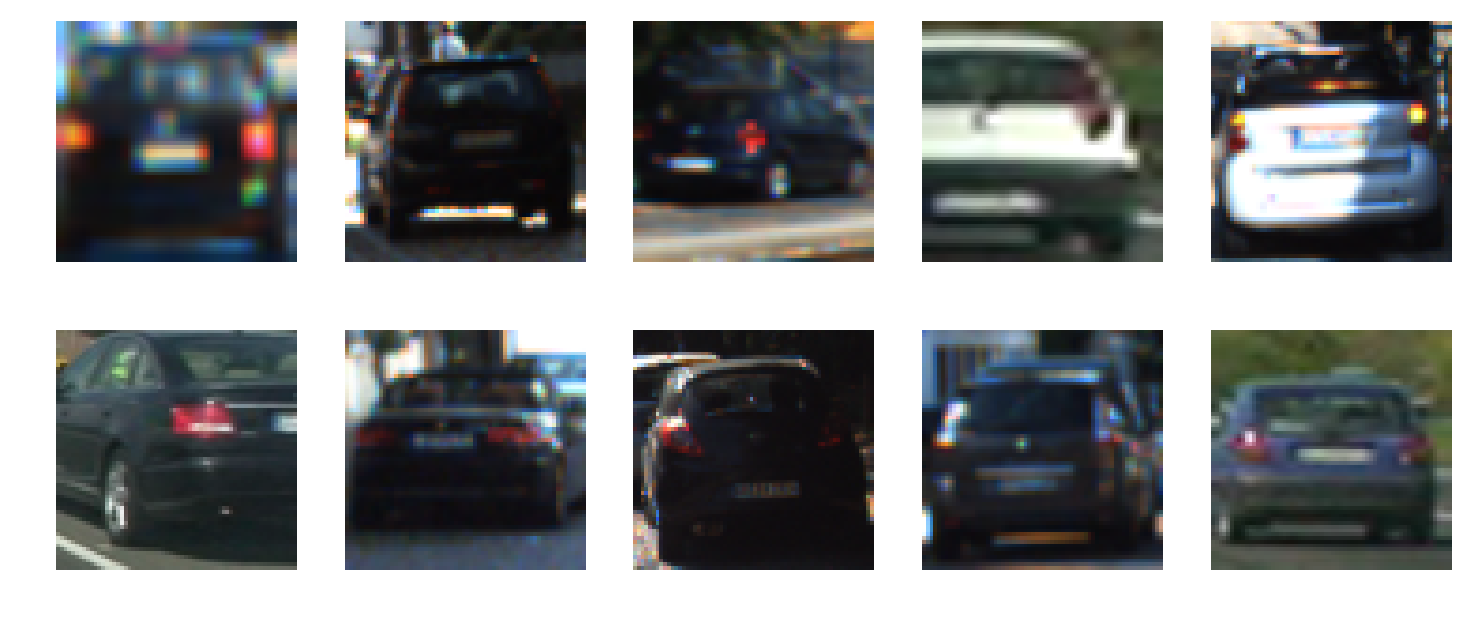

In [68]:
plt.subplots(2, 5, figsize=(12, 5), dpi=150)
for i, image in enumerate(tracker.get_random_training_images(number=10)):
    plt.subplot(2, 5, i+1)
    plot_image(image)

A sample of the training images labeled as non-vehicles:

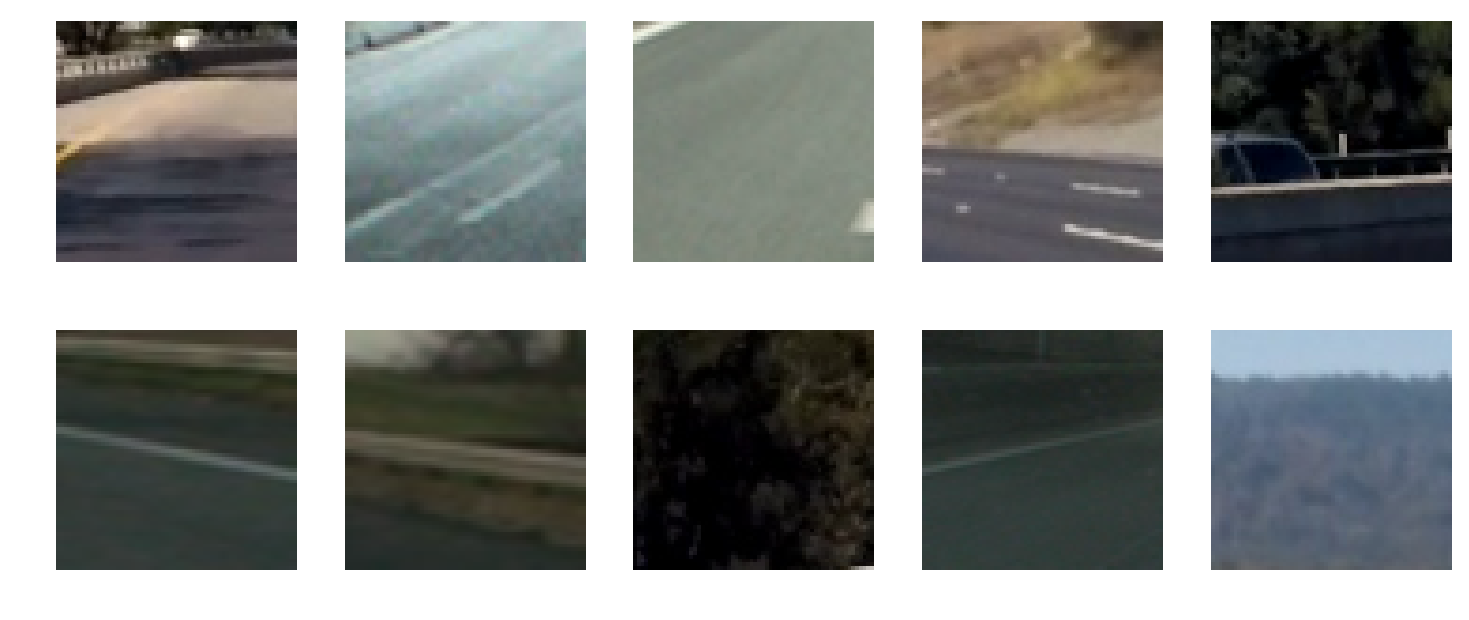

In [69]:
plt.subplots(2, 5, figsize=(12, 5), dpi=150)
for i, image in enumerate(tracker.get_random_training_images(label='non-vehicles', number=10)):
    plt.subplot(2, 5, i+1)
    plot_image(image)

## Histogram of Oriented Gradients (HOG)

Overview of what was done. Basic examples of images.

### HOG parameter choice

## Sliding Window Search

Set the sliding window parameters and the portions of the area of interest where the sliding window search should be conducted for each respective window size:

In [71]:
search_windows = {'small': {'size': (100, 100),
                            'step_y': 50,
                            'step_x': 50,
                            'search_area': 'far'},
                  'medium': {'size': (200, 200),
                             'step_y': 100,
                             'step_x': 100,
                             'search_area': 'medium'},
                  'large': {'size': (400, 400),
                            'step_y': 200,
                            'step_x': 200,
                            'search_area': 'all'}}

Define the previously mentioned search areas as rectangles covering the area of interest.  The coordinates are given as fractions relative to the bounding box of the area of interest:

In [ ]:
search_areas = {'all': ((0, 0), (1.0, 1.0)),
                'medium': ((0, 0.3), (1.0, 0.7)),
                'far': ((0, 0), (1.0, 0.4))}

Obtain a grid search object from these parameters, that can then be used to search the input images.

In [ ]:
searcher = GridSearch(search_windows, search_areas)

# Processing Video

## Filtering False Positives and Duplicate Matches